# Train the language model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Load data

In [ ]:
data_folder = '/gdrive/My Drive/data/twitter_crawl/data'

In [ ]:
sequences = pd.read_hdf(data_folder+"/preproc/sequences.hd5")


In [ ]:
X = sequences["sequences"].apply(lambda x: x[:-1])
y = sequences["sequences"].apply(lambda x: x[1:])

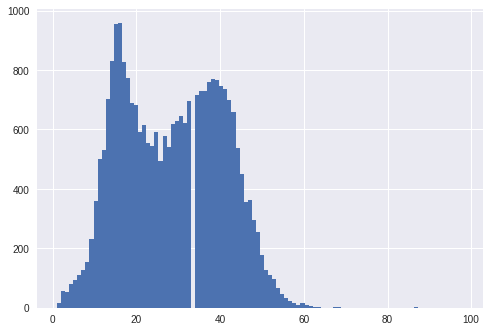

In [19]:
lengths = X.apply(len)

plt.hist(lengths, bins=100)
plt.show()

## Pad sequences

In [ ]:
# maximum number of words per sequence
max_len = 30

In [ ]:
X_padded = pad_sequences(X,max_len)
y_padded = pad_sequences(y,max_len)

### Data generator used during training

In [ ]:
# targets = to_categorical(padded)

from sklearn.preprocessing import OneHotEncoder

class Generate:
    "Makes batched and generates one-hot encoding for labels"
    
    def __init__(self,X,y,max_words,batch_size=32):
        self._X = X
        self._y = y
        self._batch_size = batch_size
        self._nbatches = X.shape[0] // batch_size
        self._remind = X.shape[0] % batch_size
        self.nbatches = self._nbatches + 1 if self._remind > 0 else 0

        self._max_words = max_words
        
        
    def __call__(self):
        index = np.arange(self._X.shape[0])
        while True:
            np.random.shuffle(index)            
            def xy(Xb,yb):
                return Xb, to_categorical(yb,self._max_words)
            for ibatch in range(self._nbatches):
                bindex = index[ibatch*self._batch_size:(ibatch+1)*self._batch_size]
                Xb = self._X[bindex]
                yb = self._y[bindex]
                yield xy(Xb,yb)
            if self._remind > 0:
                Xb = self._X[index[-self._remind:]]
                yb = self._y[index[-self._remind:]]
                yield xy(Xb,yb)
    


In [ ]:
# generate._encode.transform(padded[0,1])

In [29]:
X_padded.shape

(26786, 60)

## Model definition

In [ ]:
from keras.layers import Embedding, Input, Concatenate, GRU, Dense, Activation, Convolution1D, TimeDistributed
from keras.layers import GaussianNoise, Dropout

from keras.callbacks import CSVLogger


### Load previously prepared data

1. Embedding matrixes
1. Tokenizer and related information


In [ ]:
words_embed_mtx = np.load(data_folder+'/models/sequences/embed_mtx.npy')
hash_embed_mtx = np.load(data_folder+'/models/sequences/hash_mtx.npy')
stop_mtx = np.load(data_folder+'/models/sequences/hash_mtx.npy')


In [ ]:
import json

In [33]:
with open(data_folder+"/models/sequences/info.json","r") as fin:
    info = json.loads(fin.read())

print(info)

{'max_words': 2500, 'unk_idx': [1862, 1469, 500, 809, 1064, 550, 1302, 484, 2366, 151, 563, 2044, 941, 2489, 1582, 1747, 2495, 818, 808, 784, 864, 900, 1195, 1871, 1749, 2058, 527, 1135, 1337, 664, 2386, 2420, 1258, 1844, 165, 2312, 1554, 925, 859, 2295, 931, 2346, 1381, 2394, 348, 1658, 2352, 1692, 2458]}


In [ ]:
import pickle

with open(data_folder+"/models/sequences/tokenizer.pkl","rb") as fin:
    tk = pickle.loads(fin.read())

In [ ]:
words_embed_layer = Embedding(words_embed_mtx.shape[0],words_embed_mtx.shape[1],
                              weights=[words_embed_mtx],
                              input_length=max_len,mask_zero=True)f
hash_embed_layer = Embedding(hash_embed_mtx.shape[0],hash_embed_mtx.shape[1],
                             weights=[hash_embed_mtx],
                             input_length=max_len,mask_zero=True)
stop_layer = Embedding(stop_mtx.shape[0],stop_mtx.shape[1],
                       weights=[stop_mtx],
                       input_length=max_len,mask_zero=True)


### No fine-tuning of the embeddings

In [ ]:
words_embed_layer.trainable = False
hash_embed_layer.trainable = False
stop_layer.trainable = False


### Actual model definition

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy

In [38]:
nwords = info["max_words"]+3

inp = Input(X_padded.shape[1:])
W = words_embed_layer(inp)
H = hash_embed_layer(inp)
S = stop_layer(inp)

concat = Concatenate()([W,H,S])
L = concat

L = GaussianNoise(0.1)(L)
L = GRU(500,return_sequences=True)(L)
L = GRU(500,return_sequences=True)(L)

#L = Dropout(0.5)(L)

L = TimeDistributed(Dense(250))(L)
L = GaussianNoise(0.05)(L)
L = Activation('tanh')(L)

L = TimeDistributed(Dense(250))(L)
L = Activation('tanh')(L)

#L = Dropout(0.5)(L)

L = TimeDistributed(Dense(250))(L)
L = GaussianNoise(0.05)(L)
L = Activation('tanh')(L)

L = TimeDistributed(Dense(nwords))(L)
L = Activation('softmax')(L)
# out = rnn(concat)
out = L
embed_model = Model(inputs=inp,outputs=concat)

model = Model(inputs=inp,outputs=out)
optimzier = Adam(lr=1.e-3)
# ,decay=0.005

import keras.backend as K

def top3_accuracy(y_true,y_pred):
    y_pred = K.reshape(y_pred,(-1,y_pred.shape[-1]))
    y_true = K.reshape(K.argmax(y_true, axis=-1), (-1,))
    mask = K.cast( K.greater(y_true, 0), K.floatx()  )
    return K.sum( mask*K.cast(K.in_top_k(y_pred, y_true, 3),K.floatx()),axis=-1)/K.sum(mask)


# def top5_accuracy(y_true,y_pred):
#   return top_k_categorical_accuracy(y_true,y_pred,5)

model.compile(loss="categorical_crossentropy",optimizer=optimzier,metrics=['categorical_accuracy',top3_accuracy])

model_folder = data_folder+"/models/gru"
! mkdir -p "$model_folder"

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 25)       62525       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 2)        5004        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 60, 2)        5004        input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

### Visialize input sequences

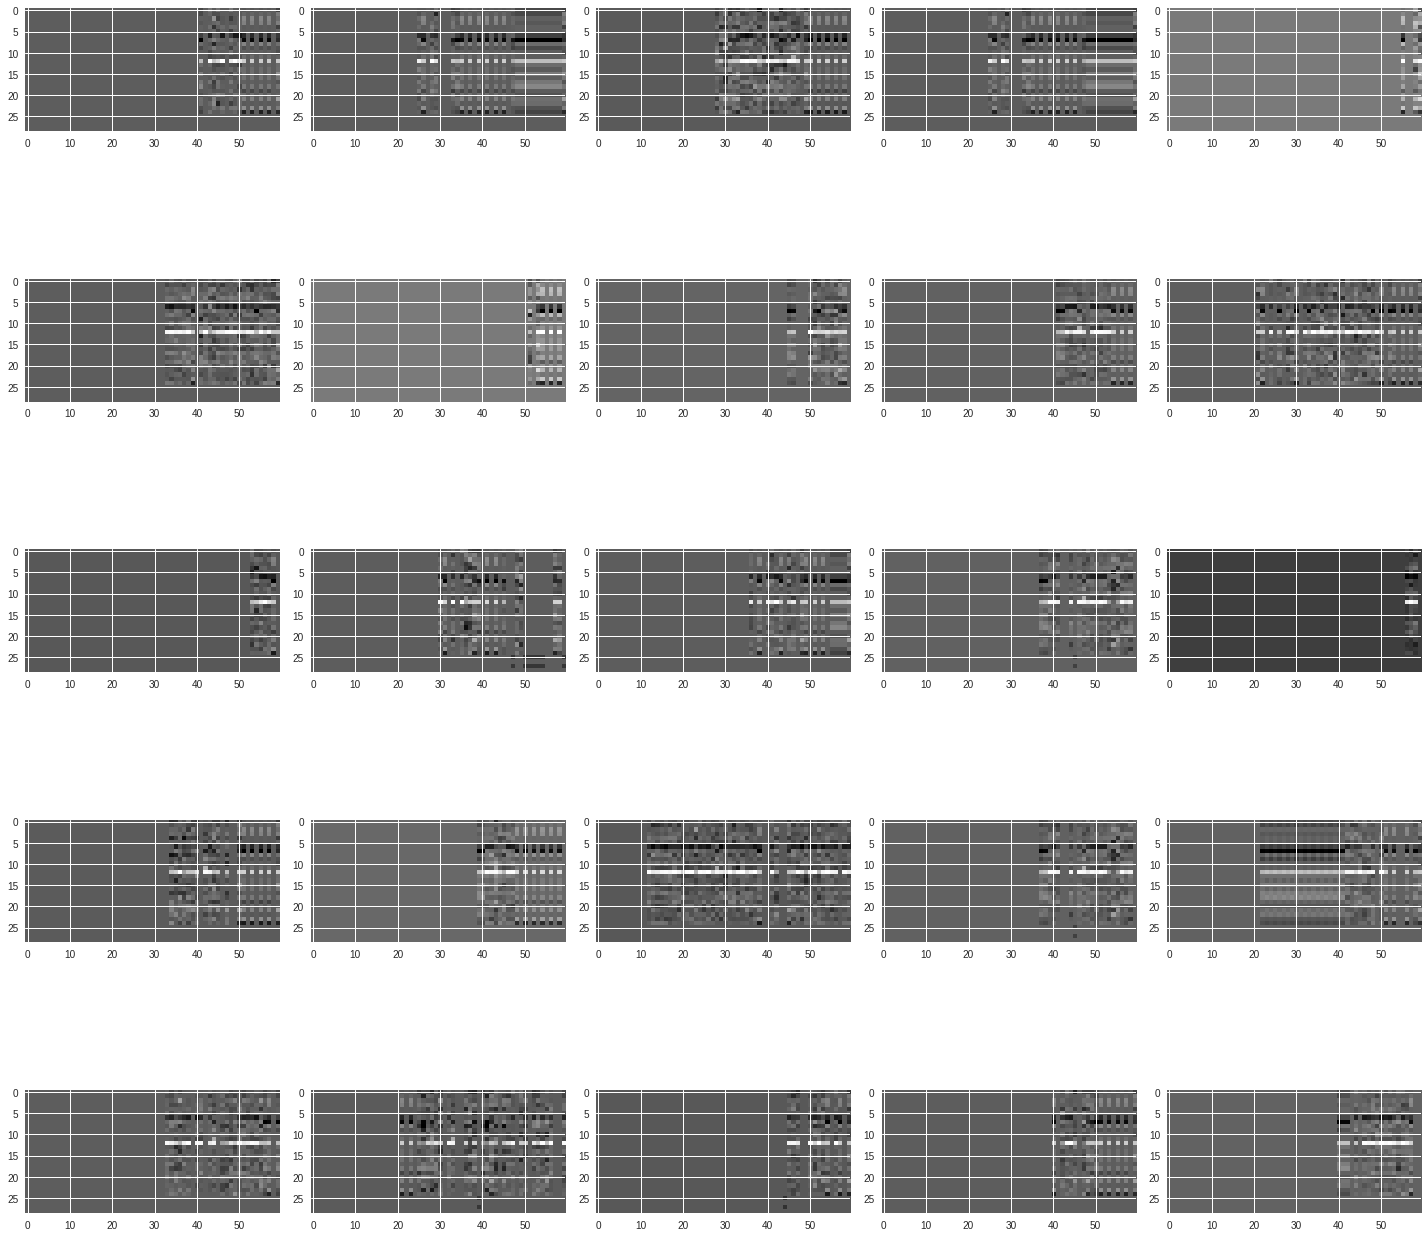

In [39]:
sentences = embed_model.predict(X_padded[:100])

fig = plt.figure(figsize=(20,20))
for isnt, snt in enumerate( np.random.choice(np.arange(sentences.shape[0]),25) ):
    plt.subplot(5,5,isnt+1)
    plt.imshow(sentences[snt].T)
plt.tight_layout()
plt.savefig("sentences.png")
plt.show()


### Keras callback to sample model predictions during training

In [ ]:
from keras.callbacks import LambdaCallback

class Sample:
  
  def __init__(self,X,y,nsamples,model,tokenizer,min_epoch,freq,prefix=model_folder):
    self._X = X
    self._y = y
    self._index = np.arange(X.shape[0])
    self._nsamples = nsamples
    self._tokenizer = tokenizer
    self._min_epoch = min_epoch
    self._freq = freq
    self._model = model
    self._prefix = prefix
    
  def __call__(self,epoch,logs):
    print(epoch)
    if epoch < self._min_epoch: return
    
    if (epoch - self._min_epoch ) % self._freq != 0: return
    
    samples = np.random.choice(self._index,self._nsamples)
    samples_X = self._X[samples]
    targets = self._y[samples]
    predictions = model.predict(samples_X).argsort(2)[:,:,-2:]
    # 
    with open(self._prefix+"/sample_%d.txt" % epoch, "w+") as fout:
      for target,prediction,inp in zip(targets,predictions,samples_X):
        first_word = (target>0).argmax()
        fout.write(self._tokenizer.sequences_to_texts([inp[first_word:]])[0]+'\n')
        fout.write(self._tokenizer.sequences_to_texts([target[first_word:]])[0]+'\n')
        fout.write(self._tokenizer.sequences_to_texts([prediction[first_word:,-1]])[0]+'\n')
        fout.write(self._tokenizer.sequences_to_texts([prediction[first_word:,-2]])[0]+'\n')
        # fout.write(self._tokenizer.sequences_to_texts([prediction[first_word+1:,-3]]))
        fout.write("----\n")
      
    
    
    
     
    
  


### Train the model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded,y_padded,test_size=0.2,random_state=12345)

X_train, X_valid, y_train, y_valid  = train_test_split(X_train,y_train,test_size=0.2,random_state=12345)

generate_train = Generate(X_train,y_train,nwords,batch_size=512)
generate_valid = Generate(X_valid,y_valid,nwords,batch_size=512)

gen_train = generate_train()
gen_valid = generate_valid()

# for ii in range(5):
#     X,y = next(gen)
#     print(X.shape,y.shape)

In [ ]:
model.fit_generator(gen_train,steps_per_epoch=generate_train.nbatches,epochs=150,
                    validation_data=gen_valid,validation_steps=generate_valid.nbatches,
                    callbacks=[ModelCheckpoint(model_folder+"/gru-model.hd5",save_best_only=True,monitor='val_top3_accuracy'),
                               LambdaCallback(on_epoch_end=Sample(X_test,y_test,15,model,tk,20,10,prefix=model_folder)),
                               CSVLogger(model_folder+'/metrics.csv')
                              ])

Epoch 1/150
34/34 [==============================] - 44s 1s/step - loss: 5.4159 - categorical_accuracy: 0.1930 - top3_accuracy: 0.3166 - val_loss: 4.8847 - val_categorical_accuracy: 0.1961 - val_top3_accuracy: 0.3373
0
Epoch 2/150
34/34 [==============================] - 38s 1s/step - loss: 4.7864 - categorical_accuracy: 0.2073 - top3_accuracy: 0.3436 - val_loss: 4.6745 - val_categorical_accuracy: 0.2206 - val_top3_accuracy: 0.3402
1
Epoch 3/150
34/34 [==============================] - 39s 1s/step - loss: 4.5546 - categorical_accuracy: 0.2229 - top3_accuracy: 0.3546 - val_loss: 4.4716 - val_categorical_accuracy: 0.2219 - val_top3_accuracy: 0.3696
2
Epoch 4/150
34/34 [==============================] - 38s 1s/step - loss: 4.3953 - categorical_accuracy: 0.2239 - top3_accuracy: 0.3756 - val_loss: 4.2975 - val_categorical_accuracy: 0.2204 - val_top3_accuracy: 0.3770
3
Epoch 5/150
34/34 [==============================] - 39s 1s/step - loss: 4.1803 - categorical_accuracy: 0.2502 - top3_accura

In [ ]:
# ! ls

In [ ]:
# ! mkdir -p "$data_folder"/models/gru_v0
# ! cp -p *.* "$data_folder"/models/gru_v0

In [ ]:
# ! ls "$data_folder"/models/gru_v0